# GeoPython Week - exercise 1
## Table of Contents
- [Data Exploration](#data_exploration)
- [Split data Train - Validation - Test](#split_data) 
- [Build pipeline](#pipeline)

In [1]:
# libraries
import pandas as pd
import numpy as np

# for plotting 
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

# define base color
base_color = sb.color_palette()[0]

import pandas_profiling

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support

In [2]:
# read data
logs = pd.read_csv("Data/logs_4wells.csv")
seismic_df=pd.read_csv('data/seismic_4wells.csv')
section_stack=pd.read_csv('data/section_2D_1.csv')

In [3]:
logs.isna().sum()

Time                0
Density             0
P_wave              0
Porosity            0
V_clay              0
Water Saturation    0
log_ID              0
Horison             0
Imp                 0
dtype: int64

<a id='data_exploration'></a>
## Data exploration

In [4]:
pandas_profiling.ProfileReport(logs)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
def plot_per_log(df, column_name, type_p='-', color=base_color):
    # plot Time vs Parameter for each well on separate subgraph
    log_ID_list=df['log_ID'].value_counts().index.tolist()
    fig, ax = plt.subplots(1,len(log_ID_list),figsize=(15,10))

    for i in list(range(len(log_ID_list))):
        ax[i].plot(df[df['log_ID']==log_ID_list[i]][column_name], -df[df['log_ID']==log_ID_list[i]].Time, 
                   type_p, color=color)
        ax[i].set_xlabel(column_name);
        ax[i].set_title(log_ID_list[i]); 
    
    ax[0].set_ylabel('Time');

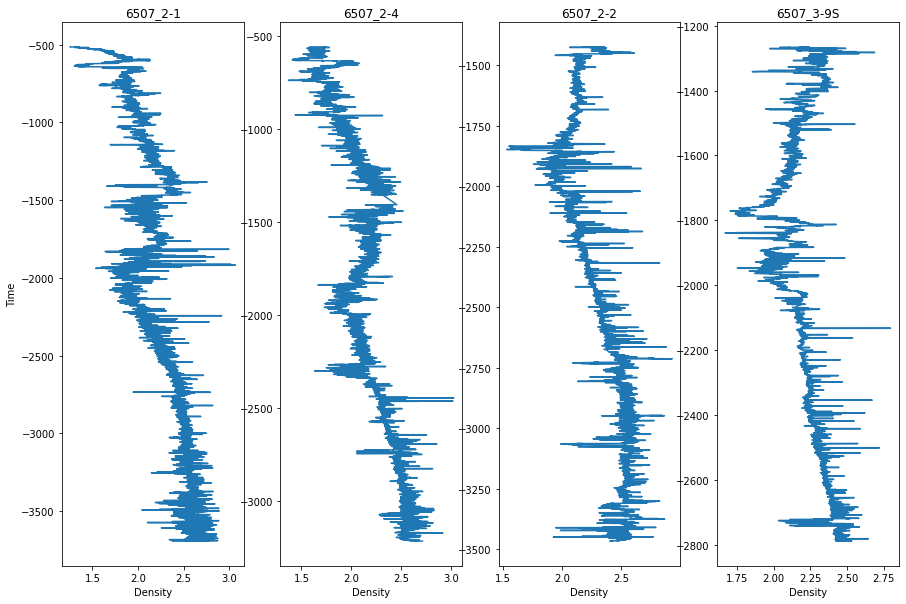

In [6]:
plot_per_log(logs, 'Density')

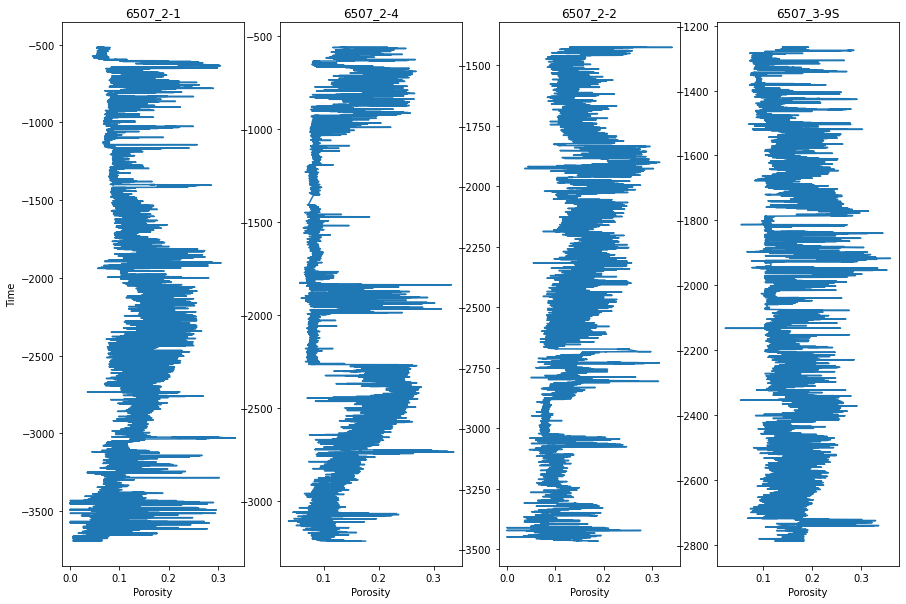

In [7]:
plot_per_log(logs, 'Porosity')

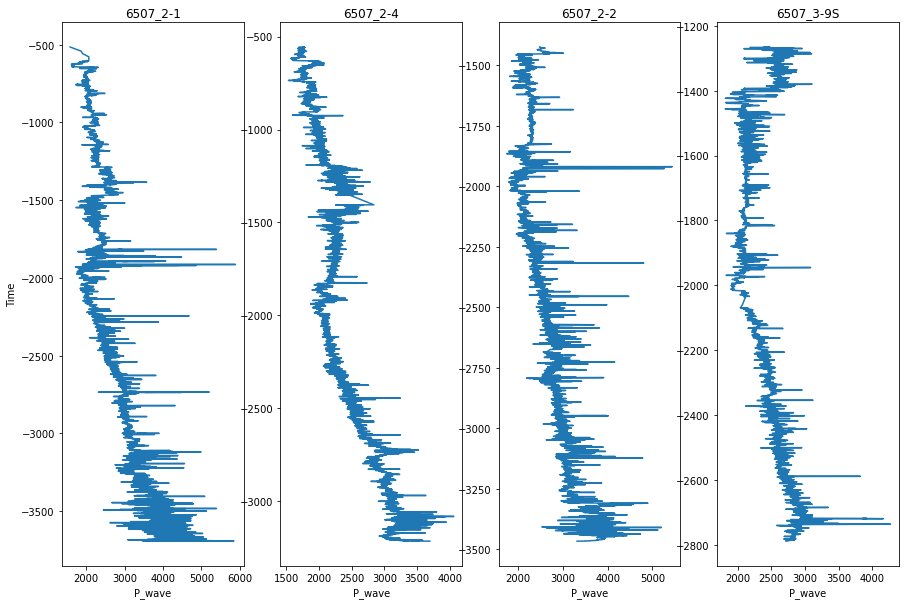

In [8]:
plot_per_log(logs, 'P_wave')

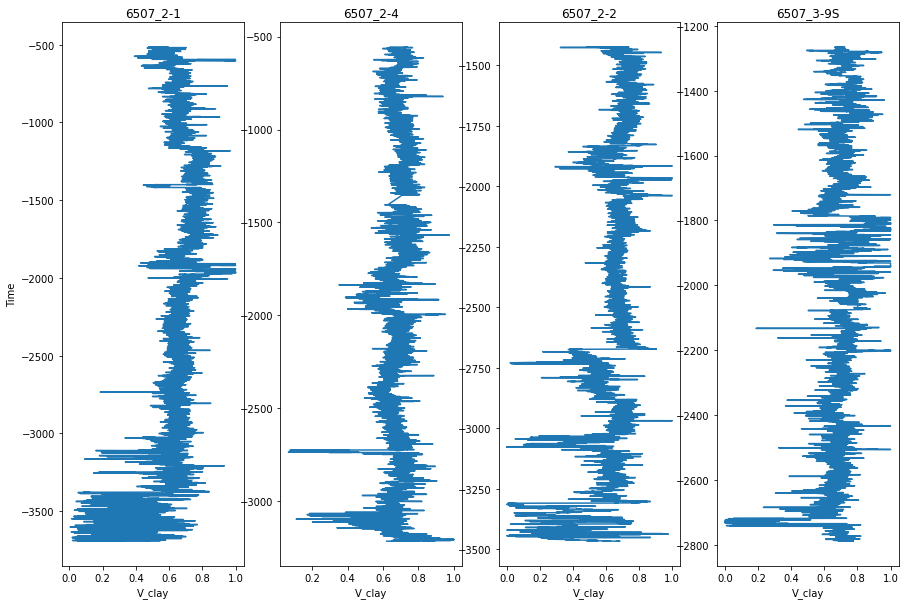

In [9]:
plot_per_log(logs, 'V_clay')

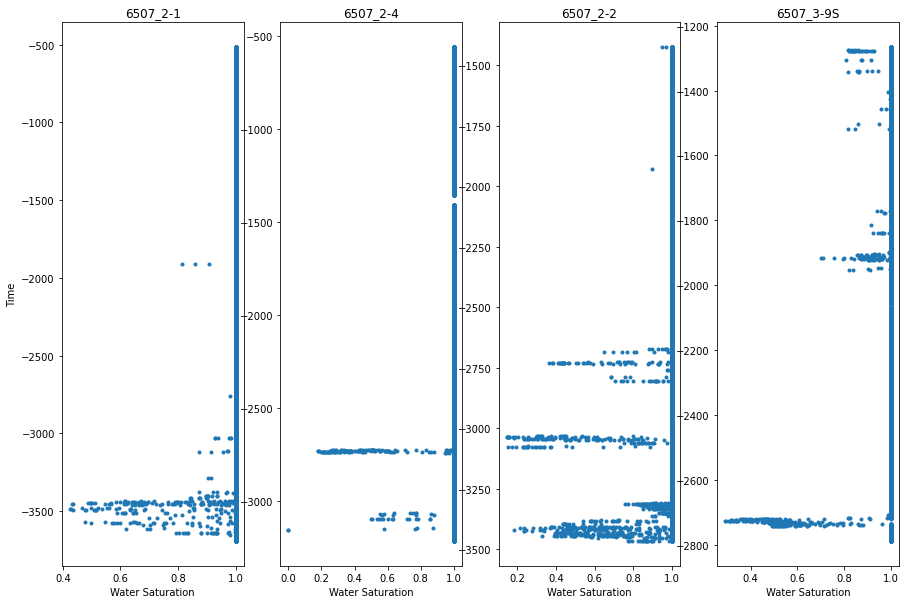

In [10]:
plot_per_log(logs, 'Water Saturation', '.')

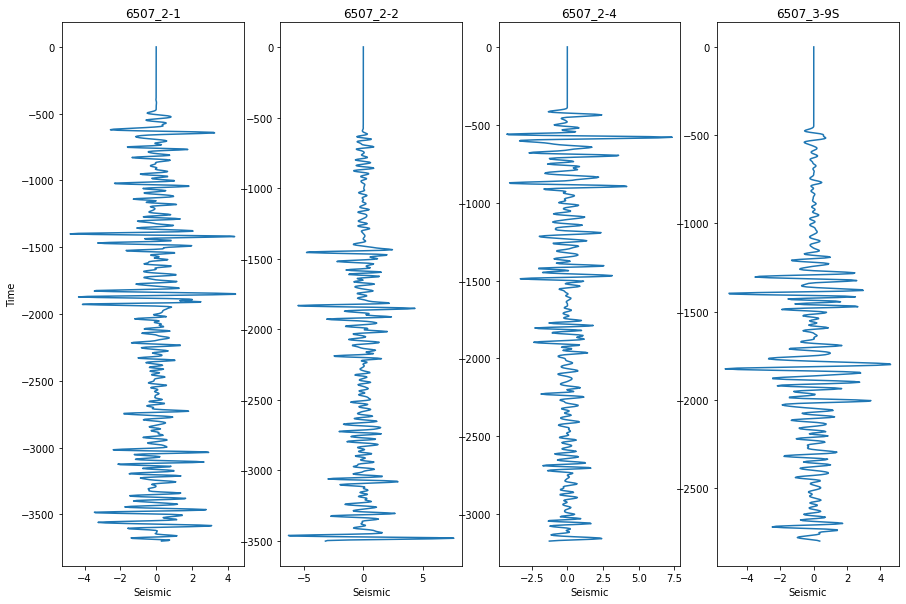

In [11]:
plot_per_log(seismic_df, 'Seismic', '-')

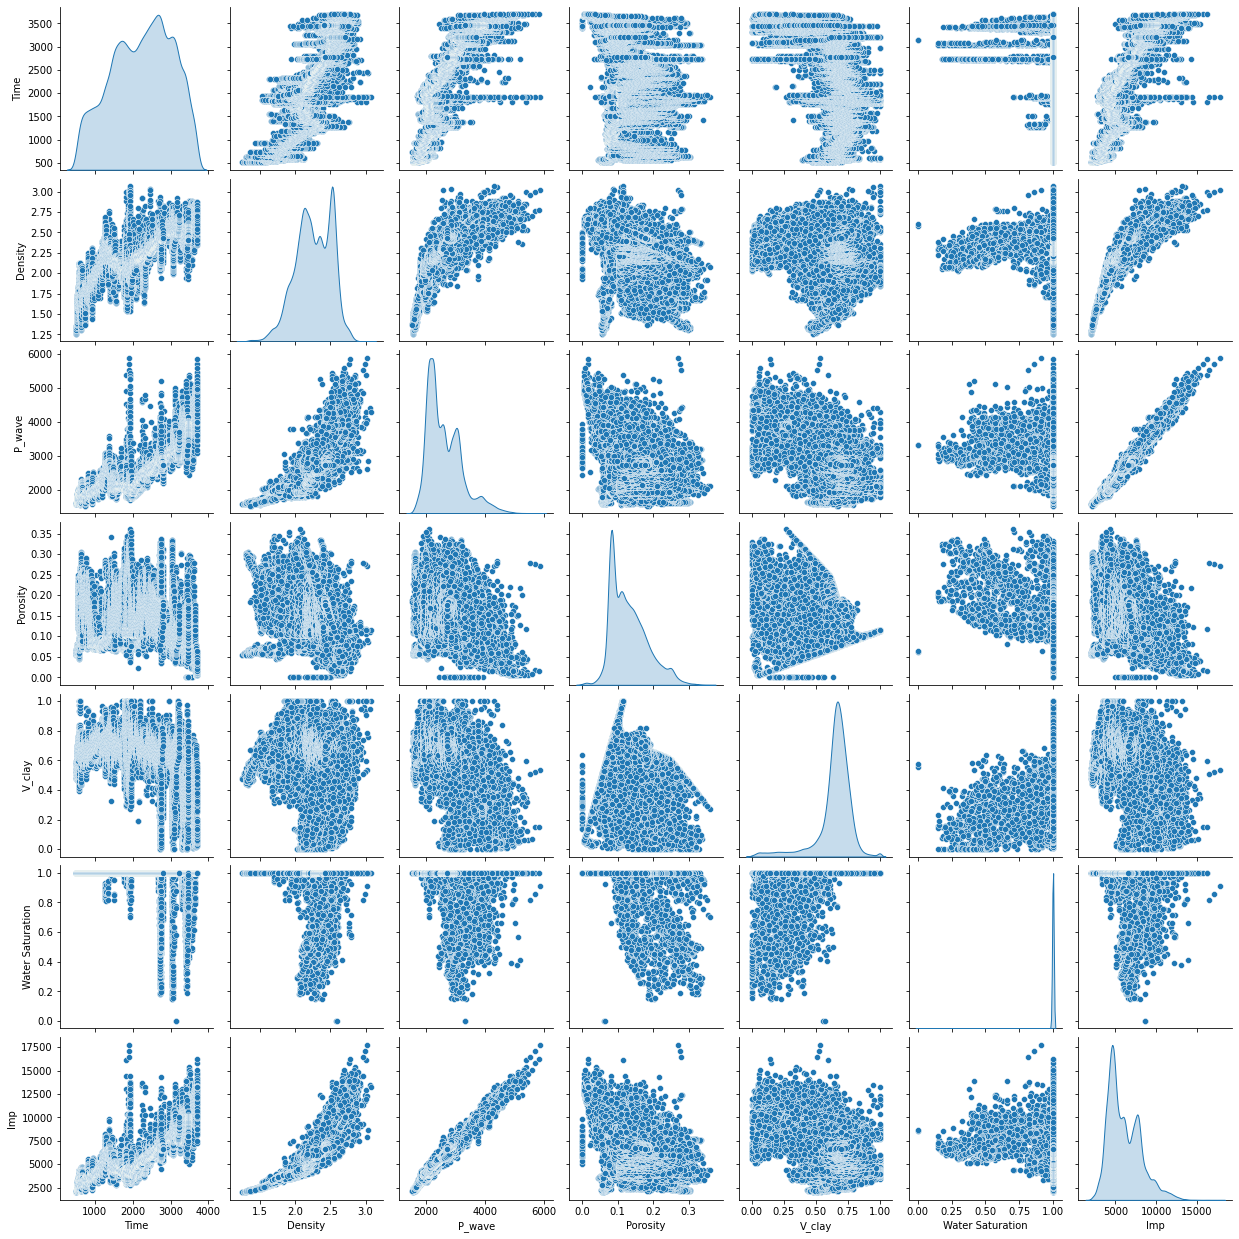

In [12]:
sb.pairplot(logs, diag_kind='kde');

In [13]:
# # uncomment this line, running time few minutes
# sb.pairplot(logs, hue='log_ID',palette="hls" ,plot_kws={'s':80}, corner=True);

### Moving average

In [14]:
# log dataframe and seismic dataframe frames has different Time step -> Moving average on logs

In [15]:
seismic_df[seismic_df['log_ID']=='6507_2-1'].head()

Time       Seismic    log_ID  QuadrTrace  SecDerInstAmpl    Integrated  \
794   0.0 -7.548390e-08  6507_2-1    0.002513        0.000018 -5.314120e-07   
795   4.0 -1.006450e-07  6507_2-1    0.002343        0.000018 -6.413220e-07   
796   8.0  3.302420e-08  6507_2-1    0.002429        0.000018 -6.156090e-07   
797  12.0  3.774200e-08  6507_2-1    0.002264       -0.000017 -5.861930e-07   
798  16.0  8.491930e-08  6507_2-1    0.002347        0.000017 -5.050610e-07   

         AWCP           Der       AWF     DomF    InstF        SecDer  \
794 -0.000959 -2.516130e-08  0.008822  20.0195  5.45333  0.000000e+00   
795 -0.000927 -2.516130e-08 -0.008777  20.0195 -5.94561  0.000000e+00   
796 -0.000958  1.336690e-07  0.008743  20.0195  5.41126  1.588310e-07   
797 -0.000926  4.717740e-09 -0.008707  20.0195 -5.90072 -1.289520e-07   
798 -0.000958  4.717740e-08  0.008656  20.0195  5.36106  4.245970e-08   

       AmpEnv       AppPolr  
794  0.001618 -1.617760e-03  
795  0.001476 -1.006450e-07  
796  0.001616  1.615640e-03  
797  0.001476  3.774200e-08  
798  0.001615  1.614630e-03

In [16]:
logs[logs['log_ID']=='6507_2-1'].head()

Time  Density     P_wave  Porosity  V_clay  Water Saturation    log_ID  \
0  514.8757   1.2545  1577.8733    0.0557  0.4820               1.0  6507_2-1   
1  515.0686   1.2542  1579.8525    0.0550  0.4766               1.0  6507_2-1   
2  515.2613   1.2724  1581.8326    0.0579  0.5014               1.0  6507_2-1   
3  515.4538   1.2821  1583.8119    0.0592  0.5126               1.0  6507_2-1   
4  515.6460   1.2897  1585.7920    0.0601  0.5201               1.0  6507_2-1   

  Horison          Imp  
0  2D-mid  1979.442055  
1  2D-mid  1981.451006  
2  2D-mid  2012.723800  
3  2D-mid  2030.605237  
4  2D-mid  2045.195942

In [17]:
# copy logs df
logs_av=logs

# add column rounded time (/4)
logs_av['Time_rounded']=np.round(logs_av['Time']/4)*4

horison_vect=logs_av.groupby(['log_ID', 'Time_rounded'])['Horison'].first().values
logs_av=logs_av.groupby(['log_ID', 'Time_rounded']).mean()
# add horison (the first value of horison in Time_rounded)
logs_av['Horison']=horison_vect

logs_av.reset_index(inplace=True)
logs_av.drop('Time', axis=1, inplace=True)
logs_av=logs_av.rename(columns={'Time_rounded':'Time'})

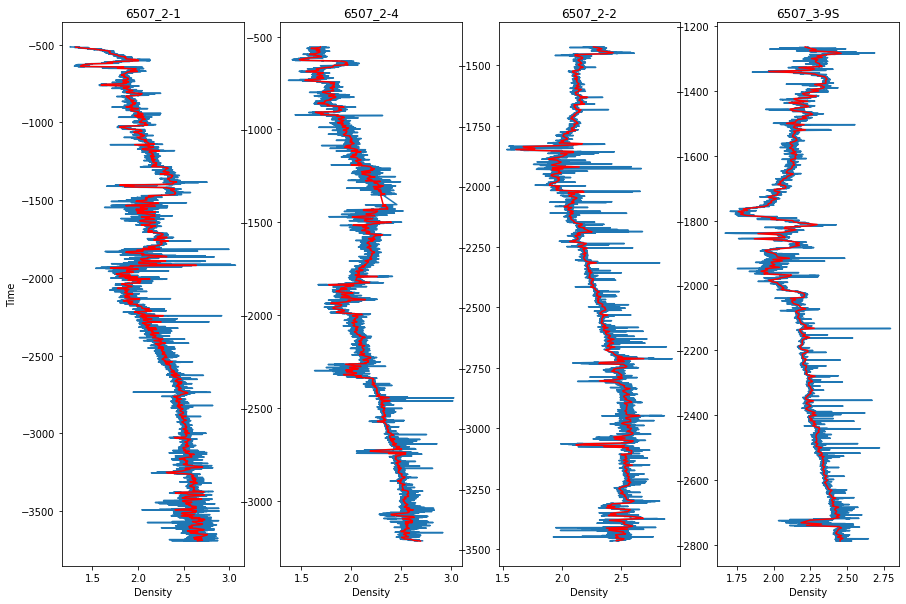

In [18]:
# plot Time vs Parameter for each well on separate subgraph
column_name='Density'
log_ID_list=logs['log_ID'].value_counts().index.tolist()
fig, ax = plt.subplots(1,len(log_ID_list),figsize=(15,10))

for i in list(range(len(log_ID_list))):
    ax[i].plot(logs[logs['log_ID']==log_ID_list[i]][column_name], -logs[logs['log_ID']==log_ID_list[i]].Time, 
                   '-', color=base_color)
    ax[i].plot(logs_av[logs_av['log_ID']==log_ID_list[i]][column_name], -logs_av[logs_av['log_ID']==log_ID_list[i]].Time, 
                   '-', color='red')
    ax[i].set_xlabel(column_name);
    ax[i].set_title(log_ID_list[i]); 

    
ax[0].set_ylabel('Time');

In [19]:
# combine logs_av and seismic_df
log_seismic_df=pd.merge(logs_av, seismic_df, on=['log_ID', 'Time'])

In [20]:
log_seismic_df['log_ID'].value_counts()

6507_2-1     795
6507_2-4     643
6507_2-2     510
6507_3-9S    381
Name: log_ID, dtype: int64

In [21]:
#log_seismic_df.isna().sum()

### Columns to use
Columns that exist in data for wells and for 2D volume


In [22]:
### Find overlapping columns between wells data and 2D data
features=(log_seismic_df.columns).intersection(section_stack.columns).to_list()
print (features)

['Time', 'Density', 'P_wave', 'Imp', 'Horison', 'Seismic', 'QuadrTrace', 'SecDerInstAmpl', 'Integrated', 'AWCP', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer', 'AmpEnv', 'AppPolr']


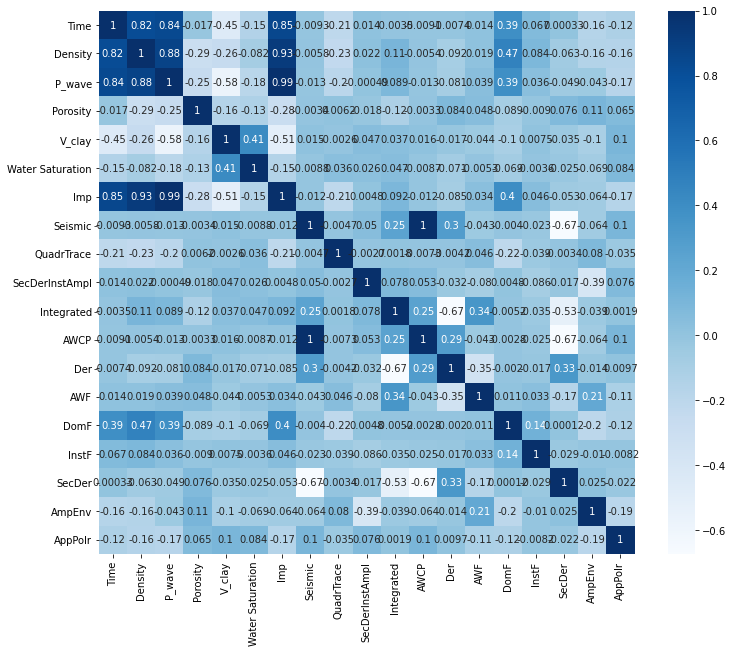

In [23]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = log_seismic_df.corr()
sb.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

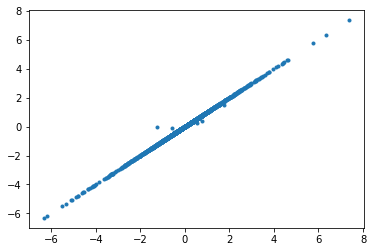

In [24]:
# we might want to get rid of AWCP as it is highly correlated with Seismic
plt.plot(log_seismic_df['Seismic'], log_seismic_df['AWCP'], '.')
# remove AWCP
features.remove('AWCP')

<a id='split_data'></a>
## Split data into Train - Validation - Test

As Test data set we'll keep one well '6507_2-4'

Target - Water Saturation 

Use only horisons: 2D-K65, 2D-BCU, 2D-bottom

In [25]:
df=log_seismic_df[(log_seismic_df['Horison']=='2D-bottom')| 
                  (log_seismic_df['Horison']=='2D-K65')| 
                  (log_seismic_df['Horison']=='2D-BCU')
                 ]

In [26]:
# define test, target, features
test_well_name='6507_2-4'
target_val=0.95
#features=[ 'Density', 'P_wave', 'Imp', 'Seismic', 'Horison']

df['target']=0
df.loc[df['Water Saturation']<=target_val, 'target']=1

<ipython-input-26-e22a943bb598>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target']=0
/Users/elenak/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [27]:
test_df=df[df['log_ID']==test_well_name]
X_test=test_df[features]
y_test=test_df['target']

data=df[df['log_ID']!=test_well_name]
X=data[features]
y=data['target']

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

<a id='pipeline'></a>
## Build pipeline

In [29]:
# find numerical and catoegorical column names
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object', 'bool']).columns
print (numerical_ix)
print (categorical_ix)

Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object')
Index(['Horison'], dtype='object')


In [30]:
# column transformation
# categorical columns -> One Hot Encoding 
# numerical column -> Scaling

t = [('cat', OneHotEncoder(drop='first'), categorical_ix), 
     ('num',StandardScaler(), numerical_ix)]

col_transform = ColumnTransformer(transformers=t)

### Logistic regression

In [31]:
# Logistic Regression
log_reg = Pipeline([
    ('prep',col_transform), 
    ('clf', LogisticRegression(max_iter=30,solver='lbfgs',random_state=42))
    ])

log_reg.fit(X_train, y_train)

/Users/elenak/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Horison'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object'))])),
                ('clf', LogisticRegression(max_iter=30, random_state=42))])

In [32]:
y_train_pred=log_reg.predict(X_train)
y_val_pred=log_reg.predict(X_val)
y_test_pred=log_reg.predict(X_test)

In [33]:
accuracy_score(y_val, y_val_pred)

0.8992248062015504

We will use precision, recall and f1- score as metrics

Use precision / recall instead 

**Precision** (also called positive predictive value) is the fraction of relevant instances among the retrieved instances 

Precision = True_positive / (True_positive + False_positive)

**Recall** (also known as sensitivity) is the fraction of the total amount of relevant instances that were actually retrieved.

Recall = True_positive / (True_positive + False_negative)

**F1-score:**

F1 = 2 * (precision * recall) / (precision + recall)

 .| Conditoin positive | Condition negative
 ---|---|---
 **Predictied condition positive**| True positive | False positive
 **Predictied condition negative**| False negative| True negative

In [34]:
def prec_recall_report(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary')      
    print ('Precision: ', prec)
    print ('Recall: ', recall)
    print ('F-score: ', fscore)
    
    
def f1_score_eval(y_true, y_pred):
    prec, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred, average='binary') 
    return fscore


def prec_recall_fscore_train_val_test(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train_pred=clf.predict(X_train)
    y_val_pred=clf.predict(X_val)
    y_test_pred=clf.predict(X_test)

    print ('Precision/ Recall/ F-score on train set : \n')
    prec_recall_report(y_train, y_train_pred)

    print ('\n Precision/ Recall/ F-score on validation set : \n')
    prec_recall_report(y_val, y_val_pred)

    print ('\n Precision/ Recall/ F-score on test set : \n')
    prec_recall_report(y_test, y_test_pred)
    
    return y_train_pred, y_val_pred, y_test_pred


def plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, title_text, logs=data, logs_4=test_df):
    fig, ax = plt.subplots(1,3,figsize=(15,10))

    #plot y_train Vs y_train_pred 
    ax[0].plot(y_train,-logs.loc[X_train.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[0].plot(y_train_pred+0.015,-logs.loc[y_train.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[0].legend(['original', 'predicted']);
    ax[0].set_xlabel('1-oil / 0-otherwise');
    ax[0].set_ylabel('Time');
    ax[0].set_title('train set'); 
    
    #plot y_val Vs y_val_pred 
    ax[1].plot(y_val,-logs.loc[X_val.index.to_list()]['Time'], 'b.' , alpha=0.5)
    ax[1].plot(y_val_pred+0.015,-logs.loc[y_val.index.to_list()]['Time'], 'r.' , alpha=0.5)
    ax[1].legend(['original', 'predicted']);
    ax[1].set_xlabel('1-oil / 0-otherwise');
    ax[1].set_ylabel('Time');
    ax[1].set_title('validation set'); 

    #plot y_test VS y_test_pred
    ax[2].plot(y_test,-logs_4['Time'], 'b.' , alpha=0.5)
    ax[2].plot(y_test_pred+0.015,-logs_4['Time'], 'r.' , alpha=0.5)
    ax[2].legend(['original', 'predicted']);
    ax[2].set_title('test set');    
    ax[2].set_xlabel('1-oil / 0-otherwise');
    
    fig.suptitle(title_text, fontsize=16)

Precision/ Recall/ F-score on train set : 

Precision:  0.6666666666666666
Recall:  0.2
F-score:  0.30769230769230765

 Precision/ Recall/ F-score on validation set : 

Precision:  0.3333333333333333
Recall:  0.08333333333333333
F-score:  0.13333333333333333

 Precision/ Recall/ F-score on test set : 

Precision:  0.03225806451612903
Recall:  0.75
F-score:  0.061855670103092786


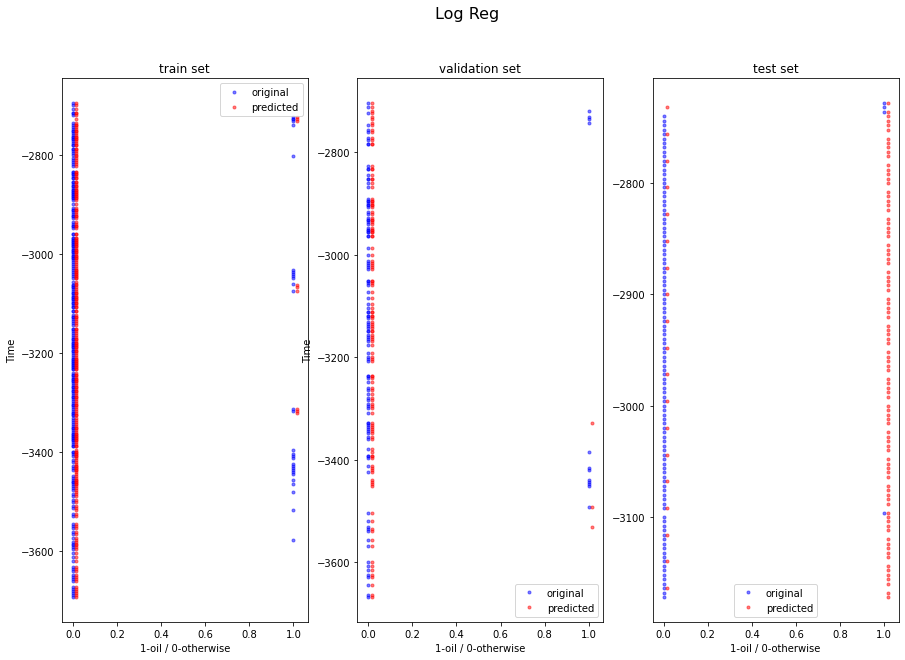

In [35]:
y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(
    log_reg, X_train, y_train, X_val, y_val, X_test, y_test)

plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'Log Reg')

### Gaussian Naive Bayes

In [36]:
# Gaussian Naive Bayes 
gnb = Pipeline([
    ('prep',col_transform), 
    ('clf', GaussianNB())
    ])
gnb.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Horison'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object'))])),
                ('clf', GaussianNB())])

Precision/ Recall/ F-score on train set : 

Precision:  0.2653061224489796
Recall:  0.43333333333333335
F-score:  0.3291139240506329

 Precision/ Recall/ F-score on validation set : 

Precision:  0.5
Recall:  0.5833333333333334
F-score:  0.5384615384615384

 Precision/ Recall/ F-score on test set : 

Precision:  0.04081632653061224
Recall:  1.0
F-score:  0.07843137254901959


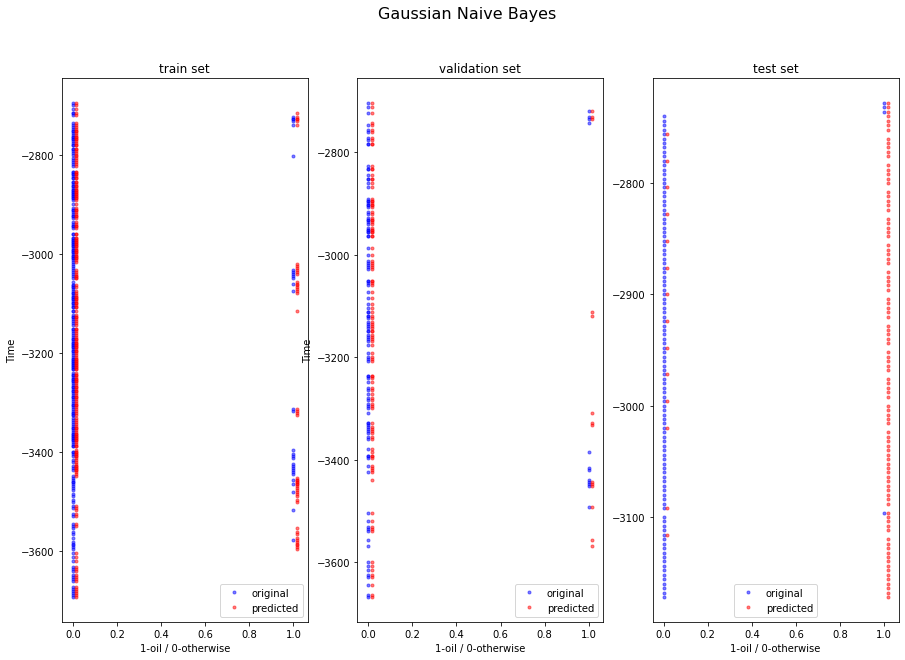

In [37]:
y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(gnb, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'Gaussian Naive Bayes')

### Support Vector Machine

In [38]:
svm=Pipeline([
    ('prep',col_transform), 
    ('clf', SVC(kernel='poly', random_state=42))
    ])

svm.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Horison'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object'))])),
                ('clf', SVC(kernel='poly', random_state=42))])

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.4666666666666667
F-score:  0.6363636363636364

 Precision/ Recall/ F-score on validation set : 

Precision:  0.8
Recall:  0.3333333333333333
F-score:  0.47058823529411764

 Precision/ Recall/ F-score on test set : 

Precision:  0.03225806451612903
Recall:  0.75
F-score:  0.061855670103092786


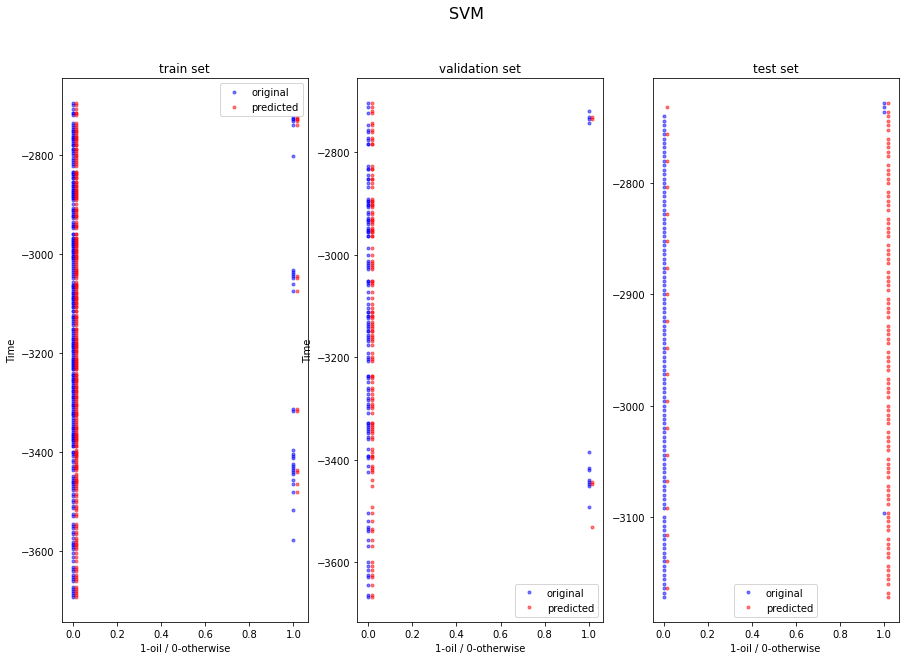

In [39]:
y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(svm, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'SVM')

### Gradient Boosting Classifier

In [40]:
gbc=Pipeline([
    ('prep',col_transform), 
    ('clf', GradientBoostingClassifier(random_state=42))
    ])

gbc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Horison'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object'))])),
                ('clf', GradientBoostingClassifier(random_state=42))])

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.4666666666666667
F-score:  0.6363636363636364

 Precision/ Recall/ F-score on validation set : 

Precision:  0.8
Recall:  0.3333333333333333
F-score:  0.47058823529411764

 Precision/ Recall/ F-score on test set : 

Precision:  0.03225806451612903
Recall:  0.75
F-score:  0.061855670103092786


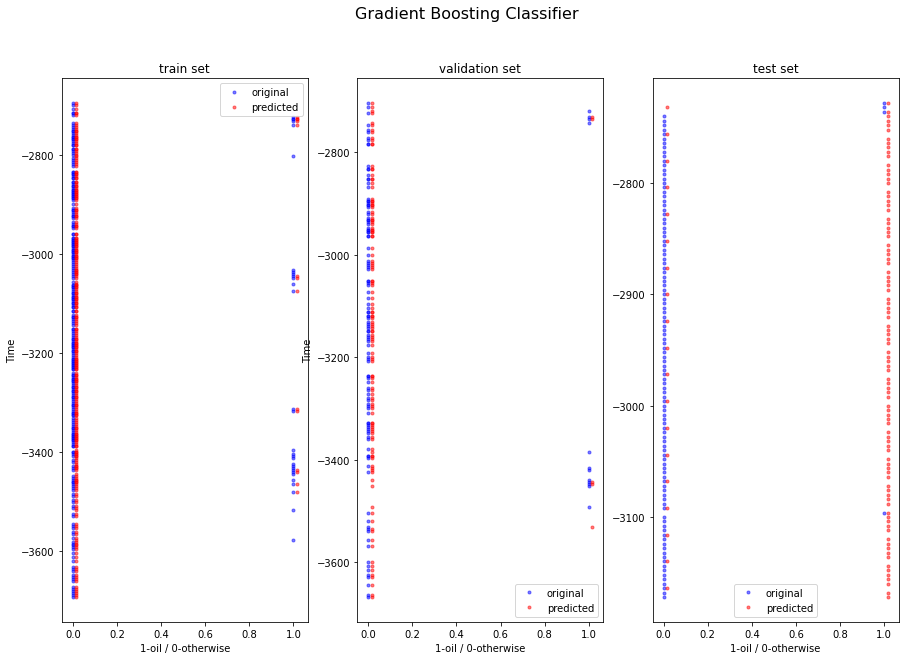

In [41]:
y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(svm, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'Gradient Boosting Classifier')

### MLPClassifier (NN)

In [42]:
mlpc= Pipeline([
    ('prep',col_transform), 
    ('clf', MLPClassifier(solver='lbfgs', alpha=1e-5,
                          hidden_layer_sizes=(5, 2), random_state=1))
     ])

mlpc.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Horison'], dtype='object')),
                                                 ('num', StandardScaler(),
                                                  Index(['Time', 'Density', 'P_wave', 'Imp', 'Seismic', 'QuadrTrace',
       'SecDerInstAmpl', 'Integrated', 'Der', 'AWF', 'DomF', 'InstF', 'SecDer',
       'AmpEnv', 'AppPolr'],
      dtype='object'))])),
                ('clf',
                 MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2),
                               random_state=1, solver='lbfgs'))])

Precision/ Recall/ F-score on train set : 

Precision:  1.0
Recall:  0.3333333333333333
F-score:  0.5

 Precision/ Recall/ F-score on validation set : 

Precision:  1.0
Recall:  0.3333333333333333
F-score:  0.5

 Precision/ Recall/ F-score on test set : 

Precision:  0.03225806451612903
Recall:  0.75
F-score:  0.061855670103092786


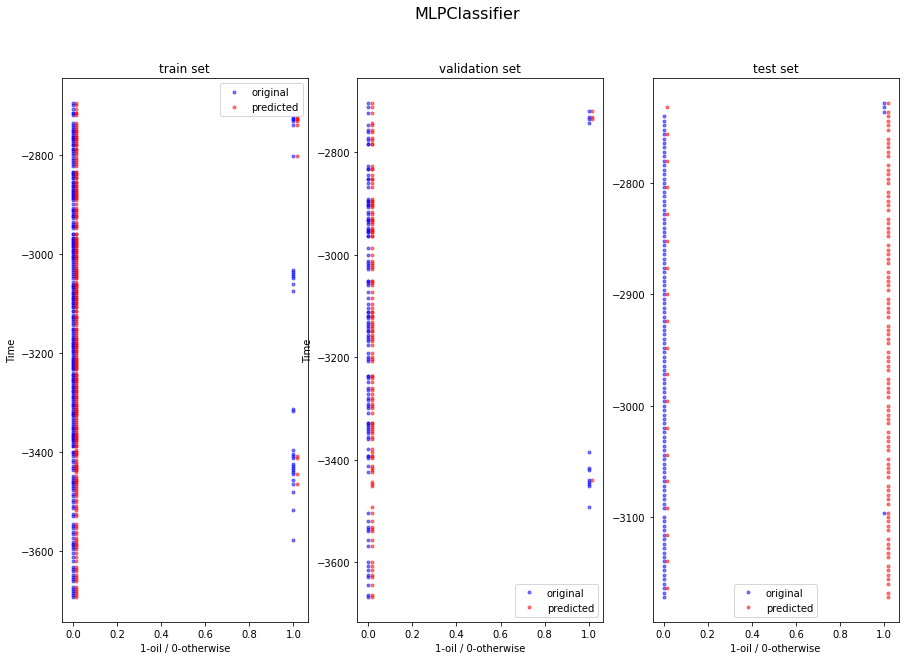

In [43]:
y_train_pred, y_val_pred, y_test_pred=prec_recall_fscore_train_val_test(mlpc, 
                                                                        X_train, y_train, 
                                                                        X_val, y_val, 
                                                                        X_test, y_test)
plot_real_predicted(X_val, y_val, y_val_pred, X_test, y_test, y_test_pred, 'MLPClassifier')

## Predict on 2D

In [44]:
data1=section_stack[(section_stack['Horison']=='2D-K65') | 
              (section_stack['Horison']=='2D-BCU') |
              (section_stack['Horison']=='2D-bottom')
             ]


In [45]:
def plot_2D_pred(df, method_name, clf, features=features):
    df['Pred']=clf.predict(df[features])
    
    df2=df[['Trace','Time', 'Pred']].groupby(['Time', 'Trace'])['Pred'].aggregate('first').unstack()
    plt.figure(figsize=(20, 10))
    plt.title (method_name, size=18)
    ax = sb.heatmap(df2,vmin=0, vmax=1, cmap="YlGnBu", cbar=False)

<ipython-input-45-7850c646f857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred']=clf.predict(df[features])


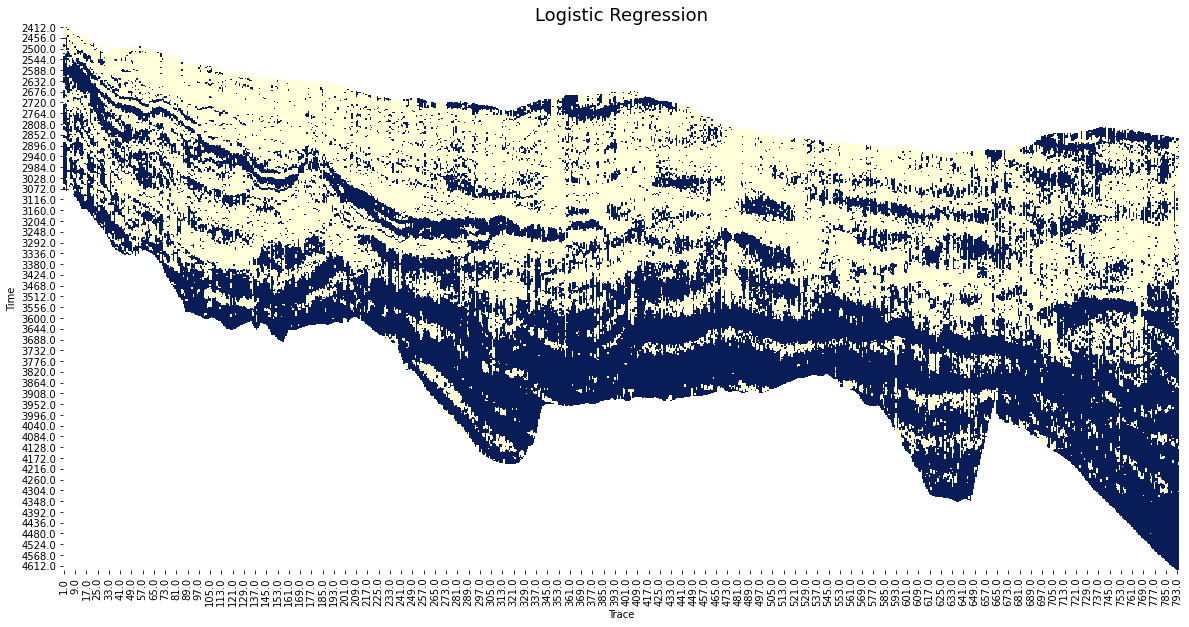

In [46]:
plot_2D_pred(data1, 'Logistic Regression', log_reg, features=features)

<ipython-input-45-7850c646f857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred']=clf.predict(df[features])


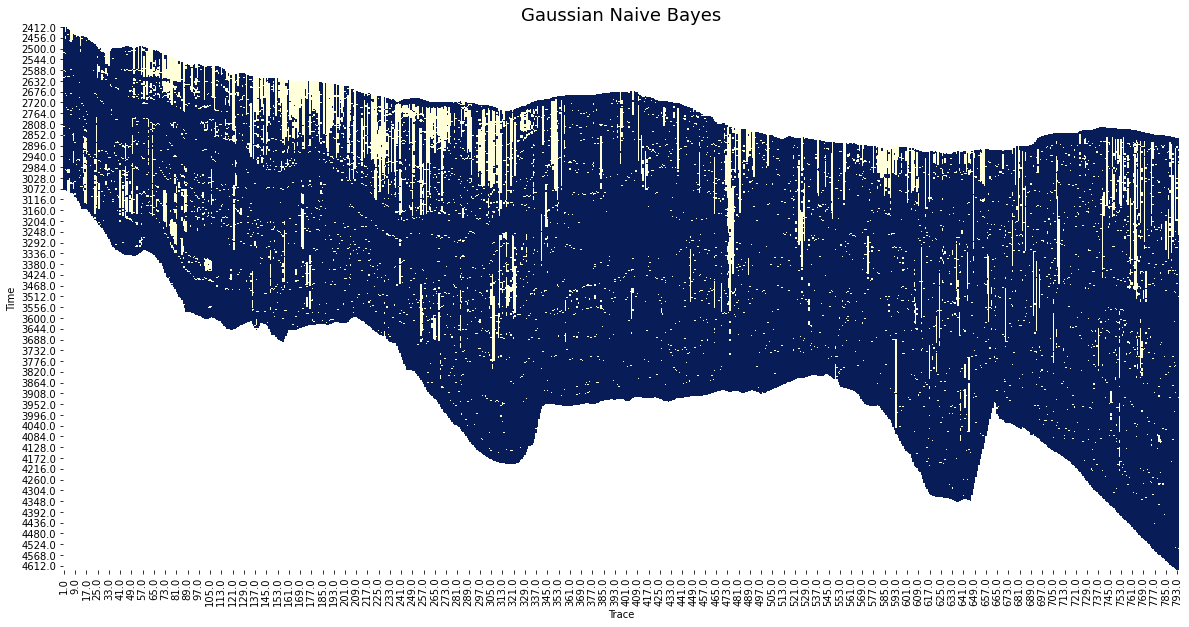

In [47]:
plot_2D_pred(data1, 'Gaussian Naive Bayes', gnb, features=features)

<ipython-input-45-7850c646f857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred']=clf.predict(df[features])


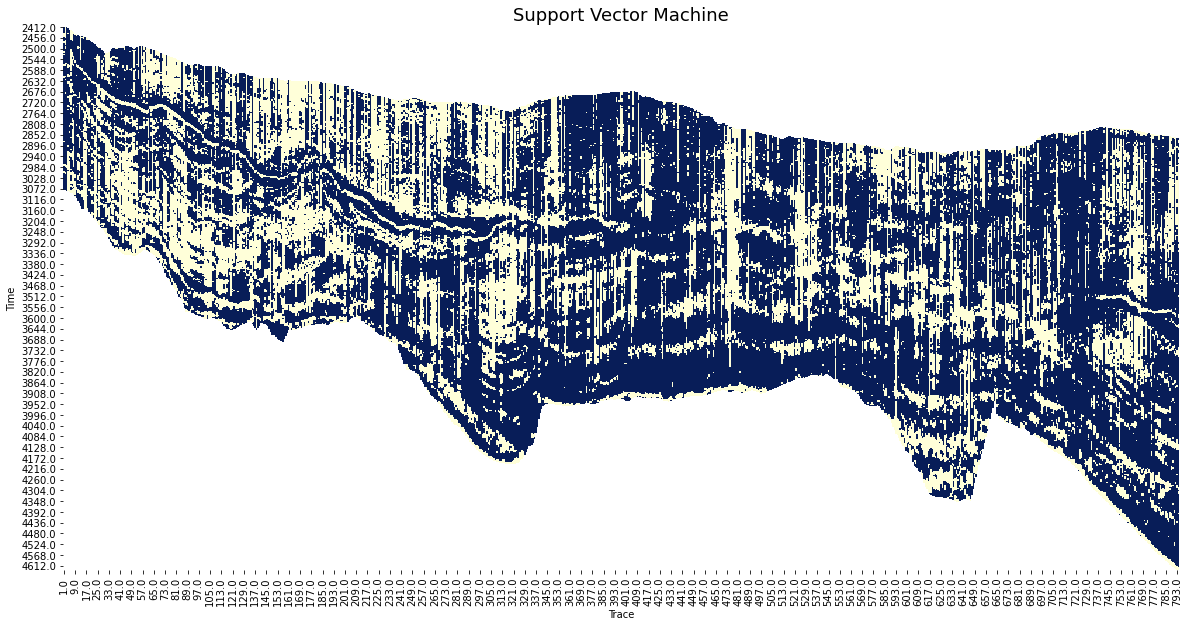

In [48]:
plot_2D_pred(data1, 'Support Vector Machine', svm, features=features)

<ipython-input-45-7850c646f857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred']=clf.predict(df[features])


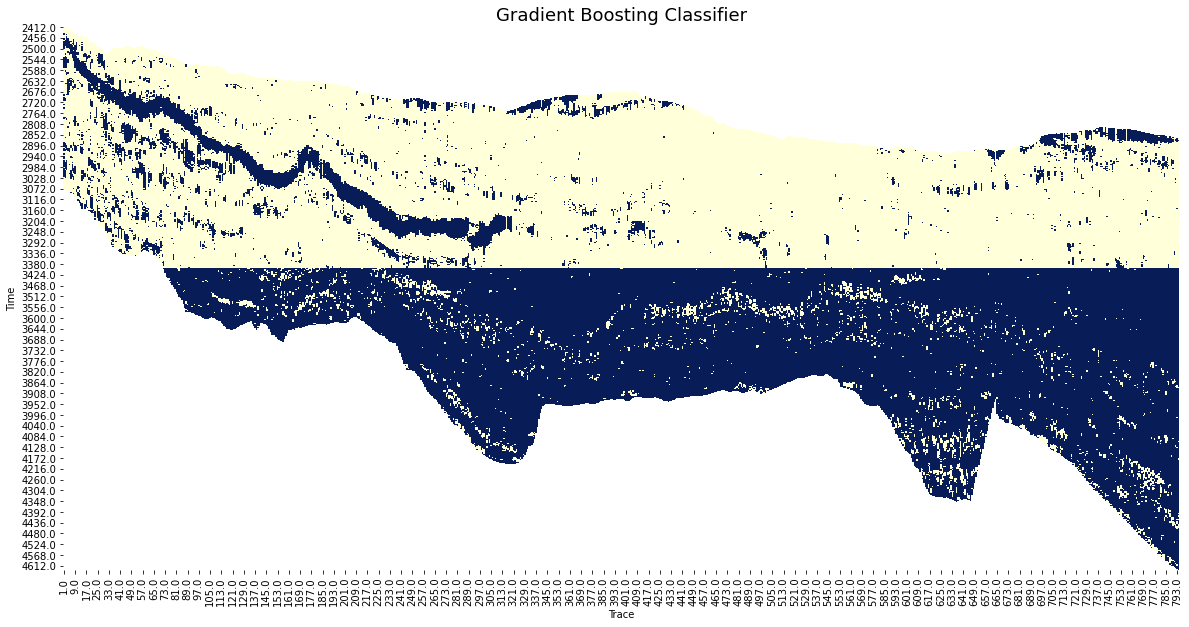

In [49]:
plot_2D_pred(data1, 'Gradient Boosting Classifier', gbc, features=features)

<ipython-input-45-7850c646f857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pred']=clf.predict(df[features])


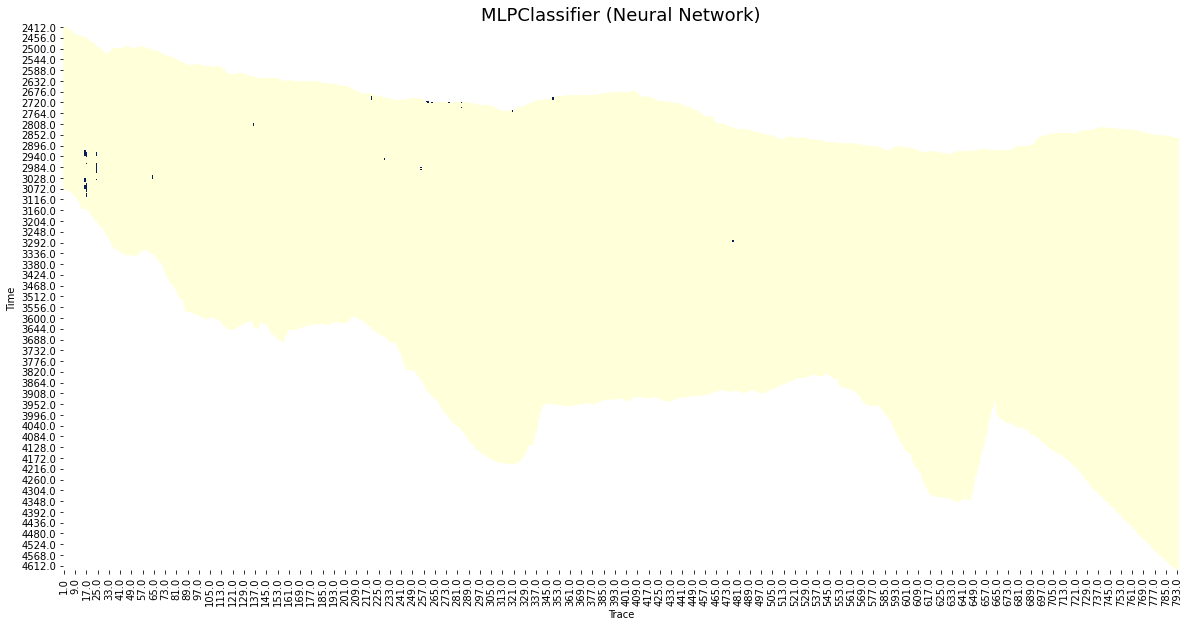

In [50]:
plot_2D_pred(data1, 'MLPClassifier (Neural Network)', mlpc, features=features)

In [51]:
features

['Time',
 'Density',
 'P_wave',
 'Imp',
 'Horison',
 'Seismic',
 'QuadrTrace',
 'SecDerInstAmpl',
 'Integrated',
 'Der',
 'AWF',
 'DomF',
 'InstF',
 'SecDer',
 'AmpEnv',
 'AppPolr']

## Next steps: 
- Play with features (develop new, select subset)
- Implement Grid search (algorithm parameter search)
- Kfold
- SMOTE (imbalance problem)